In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
df = pd.read_csv('pipeline_leak_dataset.csv')

# Display the first few rows of the dataframe
print("First 5 rows of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset Info:")
df.info()

# Display descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

First 5 rows of the dataset:
   Wellhead Temp. (C)  Wellhead Press (psi)  MMCFD- gas  \
0               53.35               1105.13       12.87   
1               72.25               1026.31        3.42   
2               65.08                722.96        6.23   
3               60.71               1557.23       11.71   
4               46.19               1304.42        8.58   

   BOPD (barrel of oil produced per day)  \
0                                1378.93   
1                                1028.75   
2                                2017.92   
3                                 558.22   
4                                1280.47   

   BWPD (barrel of water produced per day)  BSW - basic solid and water (%)  \
0                                  2812.62                            75.64   
1                                   919.92                            44.21   
2                                  1212.42                            17.55   
3                                  

Missing values in each column:
Wellhead Temp. (C)                         0
Wellhead Press (psi)                       0
MMCFD- gas                                 0
BOPD (barrel of oil produced per day)      0
BWPD (barrel of water produced per day)    0
BSW - basic solid and water (%)            0
CO2 mol. (%) @ 25 C & 1 Atm.               0
Gas Grav.                                  0
CR-corrosion defect                        0
dtype: int64


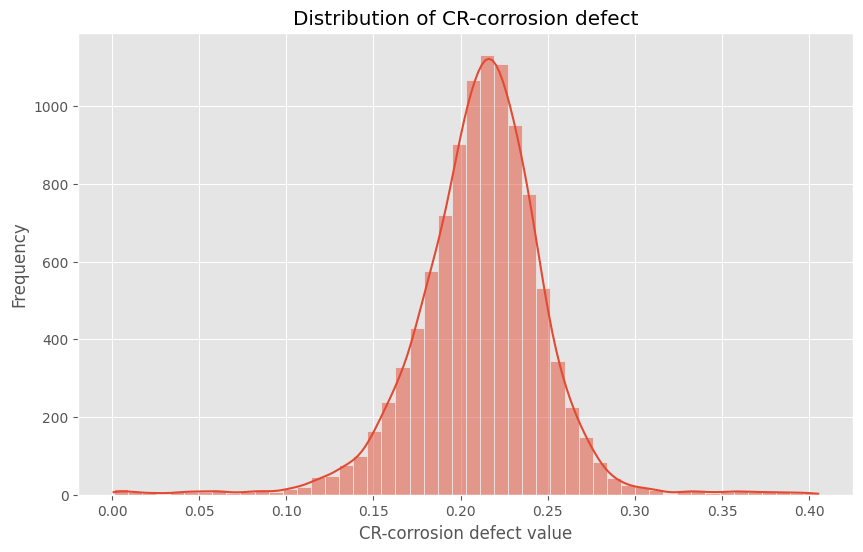

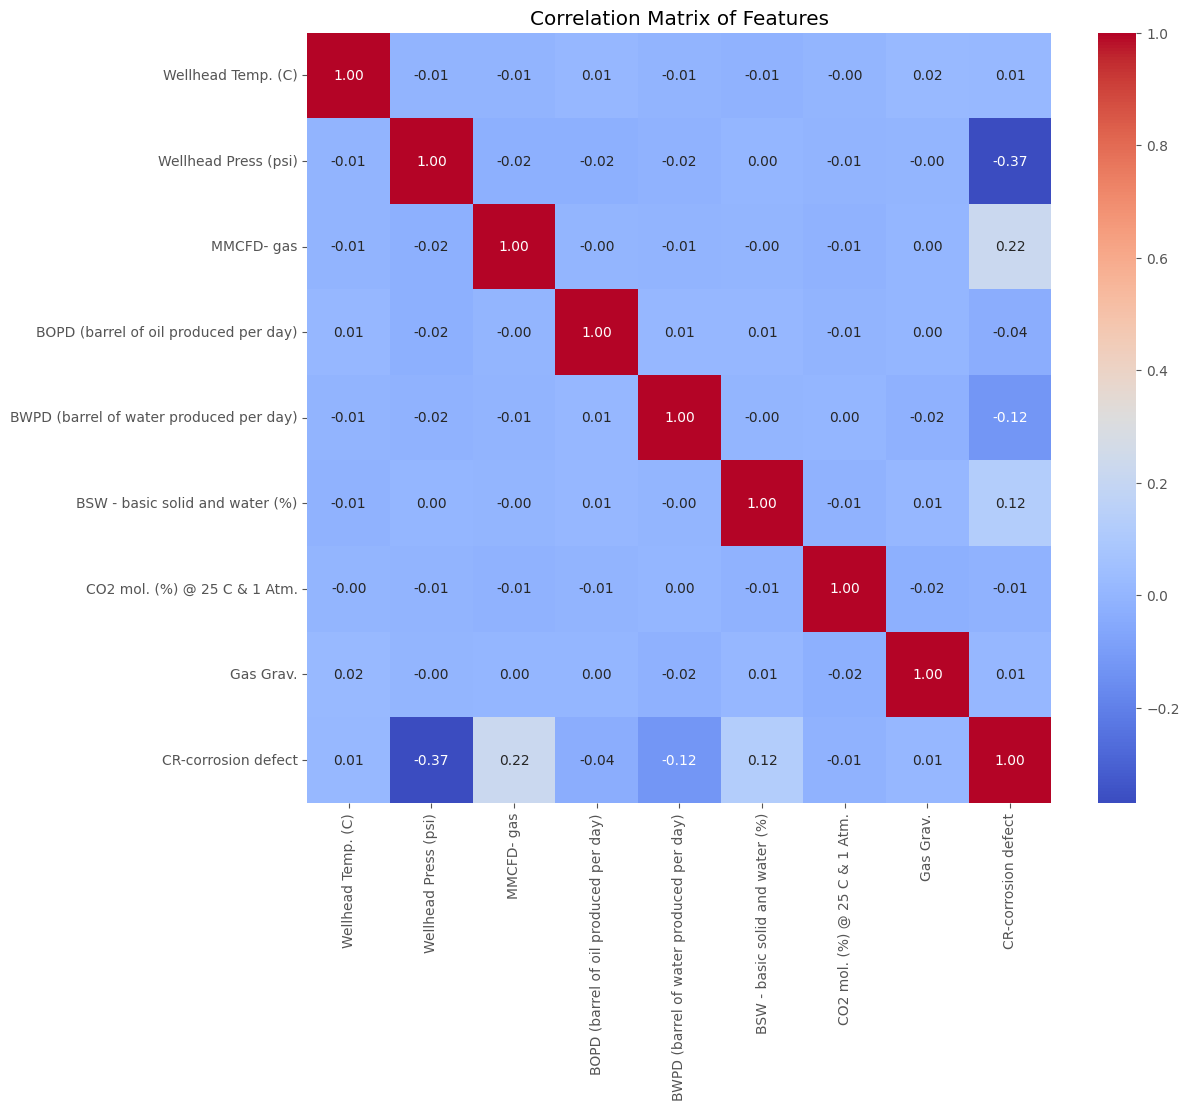

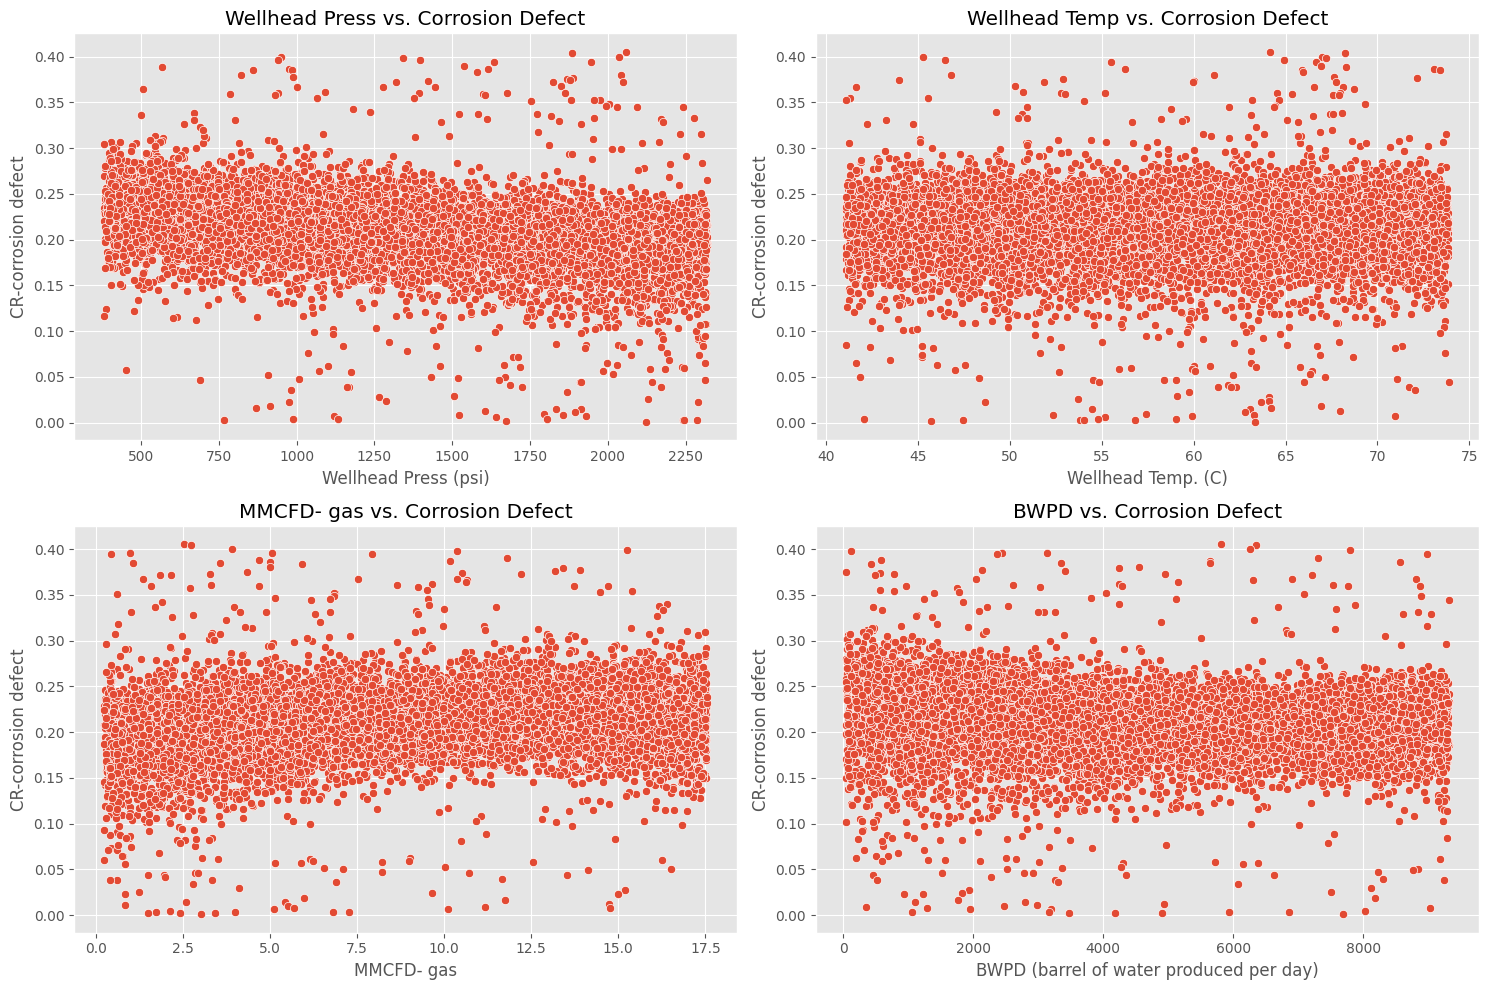

In [29]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Visualize the distribution of the target variable, 'CR-corrosion defect'
plt.figure(figsize=(10, 6))
sns.histplot(df['CR-corrosion defect'], kde=True, bins=50)
plt.title('Distribution of CR-corrosion defect')
plt.xlabel('CR-corrosion defect value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualize the correlation matrix of the features
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# Visualize the relationships between features and the target variable
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(x='Wellhead Press (psi)', y='CR-corrosion defect', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Wellhead Press vs. Corrosion Defect')

sns.scatterplot(x='Wellhead Temp. (C)', y='CR-corrosion defect', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Wellhead Temp vs. Corrosion Defect')

sns.scatterplot(x='MMCFD- gas', y='CR-corrosion defect', data=df, ax=axes[1, 0])
axes[1, 0].set_title('MMCFD- gas vs. Corrosion Defect')

sns.scatterplot(x='BWPD (barrel of water produced per day)', y='CR-corrosion defect', data=df, ax=axes[1, 1])
axes[1, 1].set_title('BWPD vs. Corrosion Defect')

plt.tight_layout()
plt.show()

Using the 80th percentile as threshold: 0.2376 for 'CR-corrosion defect'
Applying outlier capping to the following numerical columns: ['Wellhead Temp. (C)', 'Wellhead Press (psi)', 'MMCFD- gas', 'BOPD (barrel of oil produced per day)', 'BWPD (barrel of water produced per day)', 'BSW - basic solid and water (%)', 'CO2 mol. (%) @ 25 C & 1 Atm.', 'Gas Grav.']

Outlier capping applied to numerical columns.


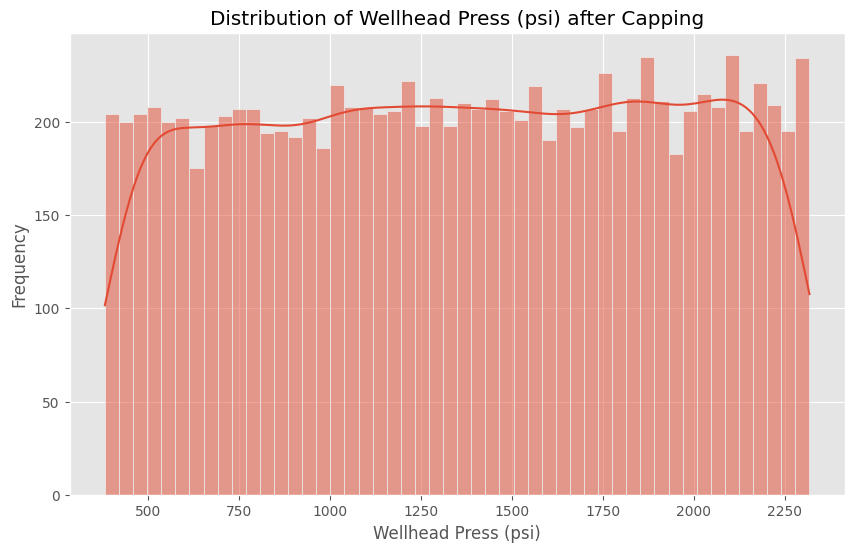


Class distribution in the training set (after using 80th percentile threshold):
is_leak
0    0.800615
1    0.199385
Name: proportion, dtype: float64


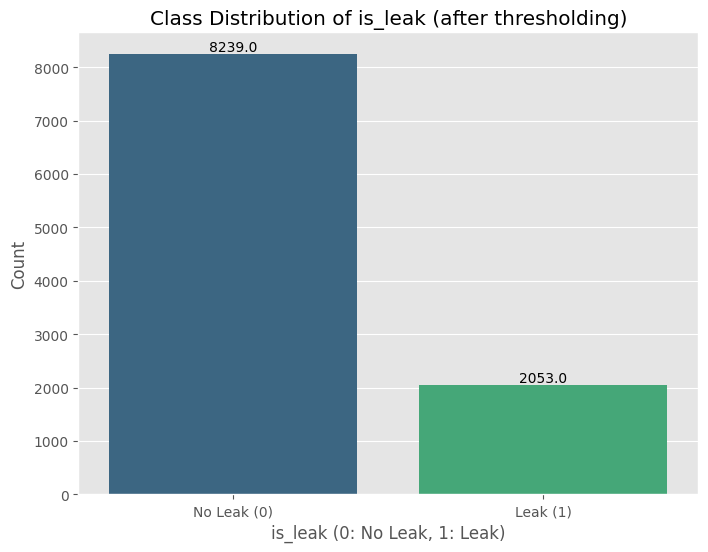

Class distribution after thresholding:
is_leak
0    8239
1    2053
Name: count, dtype: int64

Class distribution (normalized) after thresholding:
is_leak
0    0.800525
1    0.199475
Name: proportion, dtype: float64


In [30]:
# Define the threshold for 'leak' based on a manual value
threshold = df['CR-corrosion defect'].quantile(0.80)
print(f"Using the 80th percentile as threshold: {threshold:.4f} for 'CR-corrosion defect'")

# Create the binary target variable 'is_leak'
df['is_leak'] = (df['CR-corrosion defect'] > threshold).astype(int)

# Drop the original continuous target and any irrelevant features for the model
df_model = df.drop(columns=['CR-corrosion defect'])

# Define features (X) and target (y)
X = df_model.drop('is_leak', axis=1)
y = df_model['is_leak']


# Outlier Detection and Treatment using Capping by Interquartile Range

# Identify numerical columns (excluding the target variable if it's already created)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# If 'CR-corrosion defect' or 'is_leak' are still in numerical_cols, remove them
if 'CR-corrosion defect' in numerical_cols:
    numerical_cols.remove('CR-corrosion defect')
if 'is_leak' in numerical_cols:
    numerical_cols.remove('is_leak')
if 'is_leak_manual' in numerical_cols:
    numerical_cols.remove('is_leak_manual')


print(f"Applying outlier capping to the following numerical columns: {numerical_cols}")

# Apply capping to outliers using IQR
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print("\nOutlier capping applied to numerical columns.")

# You might want to re-visualize distributions after capping to see the effect
# For example:
plt.figure(figsize=(10, 6))
sns.histplot(df['Wellhead Press (psi)'], kde=True, bins=50)
plt.title('Distribution of Wellhead Press (psi) after Capping')
plt.xlabel('Wellhead Press (psi)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training data into training and validation sets (75/25 split from the 80% original)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Check the class distribution in the training set
print("\nClass distribution in the training set (after using 80th percentile threshold):")
print(y_train.value_counts(normalize=True))

# Visualize the class distribution of the binary target variable 'is_leak' after thresholding
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_leak', data=df, palette='viridis') # Use 'viridis' palette for different colors
plt.title('Class Distribution of is_leak (after thresholding)')
plt.xlabel('is_leak (0: No Leak, 1: Leak)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Leak (0)', 'Leak (1)'])


# Add count labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

print("Class distribution after thresholding:")
print(df['is_leak'].value_counts())
print("\nClass distribution (normalized) after thresholding:")
print(df['is_leak'].value_counts(normalize=True))

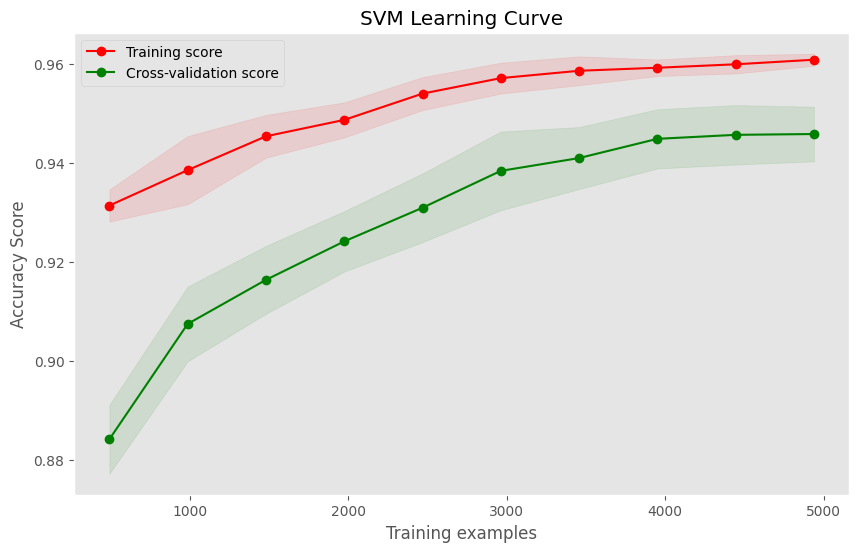

Final Cross-Validation Accuracy (mean): 0.9459
Training the SVM model...
Training complete.


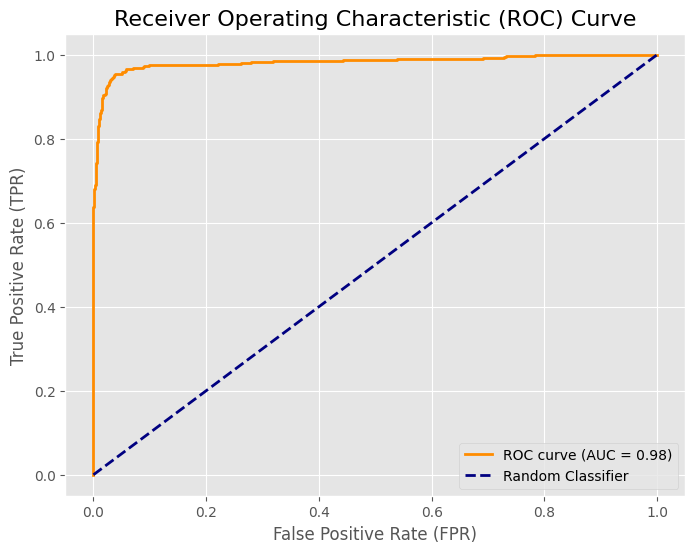

ROC-AUC Score: 0.9831


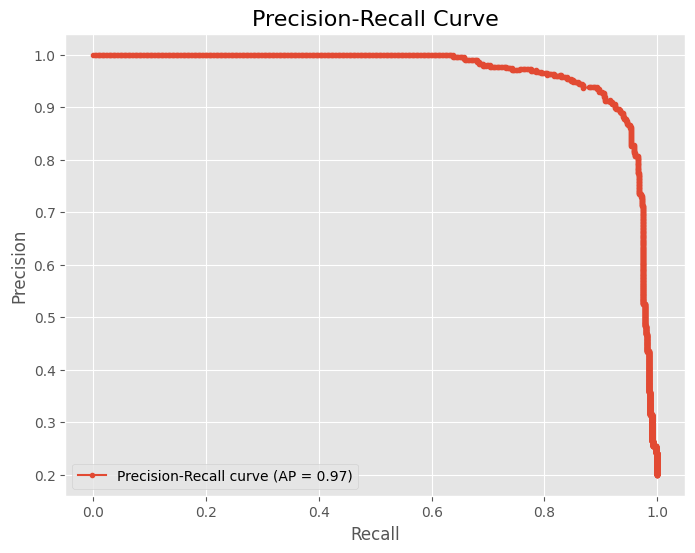

Average Precision (AP) Score: 0.9657

SVM Model Test Accuracy: 0.9568

SVM Model Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1648
           1       0.96      0.82      0.88       411

    accuracy                           0.96      2059
   macro avg       0.96      0.90      0.93      2059
weighted avg       0.96      0.96      0.96      2059



In [35]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve
import pandas as pd
import numpy as np

# --- Model 1: Imbalanced Data ---
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Generate learning curve data
# train_sizes: Percentage of the training set to use for each step
train_sizes, train_scores, test_scores = learning_curve(
    svm_model, 
    X_train_scaled, 
    y_train, 
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("SVM Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.grid()

# Plot the mean training and test scores
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# Plot the standard deviation to show variance
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.show()

# Print the final cross-validation accuracy
print(f"Final Cross-Validation Accuracy (mean): {test_scores_mean[-1]:.4f}")

# Train the SVM model
print("Training the SVM model...")
svm_model.fit(X_train_scaled, y_train)
print("Training complete.")

# Get the probability scores for the validation set
y_probs_baseline = svm_model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_probs_baseline)

# Get FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs_baseline)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

auc_score = roc_auc_score(y_test, y_probs_baseline)
print(f"ROC-AUC Score: {auc_score:.4f}")

# Get precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, y_probs_baseline)

# Calculate the Average Precision score
ap_score = average_precision_score(y_test, y_probs_baseline)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Precision-Recall curve (AP = {ap_score:.2f})')
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

print(f"Average Precision (AP) Score: {ap_score:.4f}")

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Model Test Accuracy: {accuracy:.4f}")

# Print the classification report
print("\nSVM Model Classification Report:")
print(classification_report(y_test, y_pred_svm))

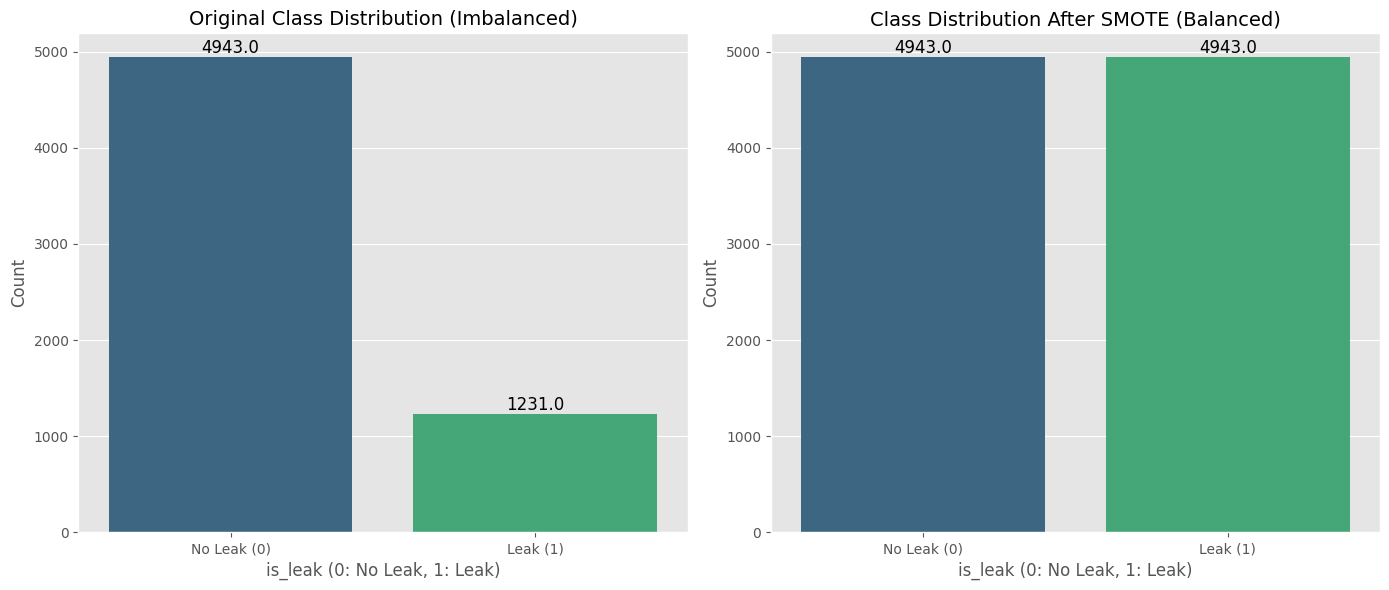

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# --- Assume X and y are already defined from your dataset ---

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the SCALED training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- Create DataFrames for plotting ---

# DataFrame for the original data class counts
original_counts = y_train.value_counts().reset_index()
original_counts.columns = ['is_leak', 'Count']

# DataFrame for the resampled data class counts
resampled_counts = y_train_resampled.value_counts().reset_index()
resampled_counts.columns = ['is_leak', 'Count']

# --- Create the bar charts ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the original data distribution
sns.barplot(x='is_leak', y='Count', data=original_counts, ax=ax1, palette='viridis')
ax1.set_title('Original Class Distribution (Imbalanced)', fontsize=14)
ax1.set_xlabel('is_leak (0: No Leak, 1: Leak)')
ax1.set_ylabel('Count')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['No Leak (0)', 'Leak (1)'])

# Add count labels on top of the bars
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=12)

# Plot the resampled data distribution
sns.barplot(x='is_leak', y='Count', data=resampled_counts, ax=ax2, palette='viridis')
ax2.set_title('Class Distribution After SMOTE (Balanced)', fontsize=14)
ax2.set_xlabel('is_leak (0: No Leak, 1: Leak)')
ax2.set_ylabel('Count')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['No Leak (0)', 'Leak (1)'])

# Add count labels on top of the bars
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

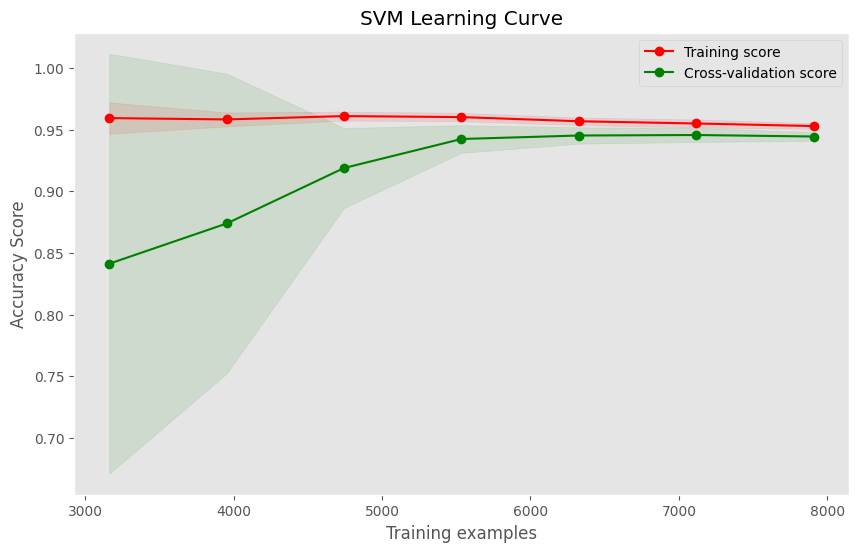

Final Cross-Validation Accuracy (mean): 0.9445
Training the SVM model...
Training complete.


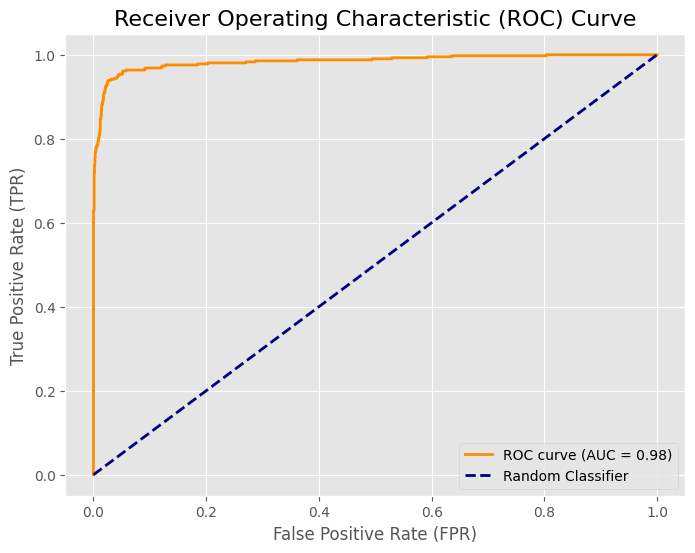

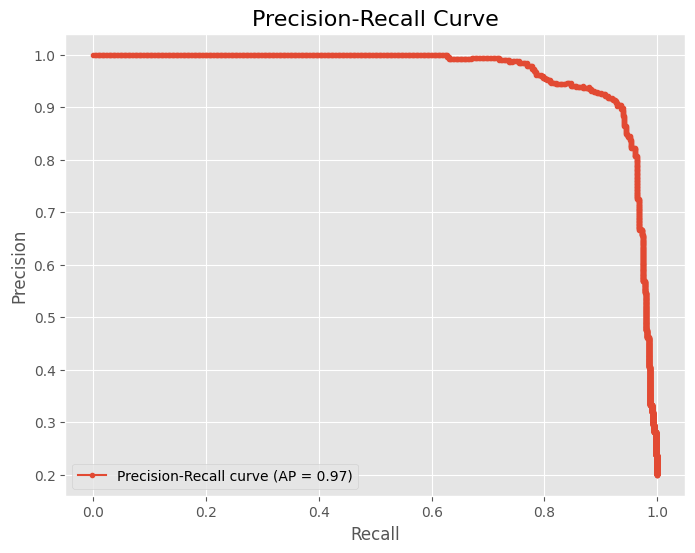

Average Precision (AP) Score: 0.9660

SVM Model Test Accuracy: 0.9539

SVM Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1648
           1       0.84      0.95      0.89       411

    accuracy                           0.95      2059
   macro avg       0.91      0.95      0.93      2059
weighted avg       0.96      0.95      0.95      2059



In [37]:

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import learning_curve
import pandas as pd
import numpy as np

# --- Model 2: Balanced Data ---
svm_model_smote = SVC(kernel='rbf', probability=True, random_state=42)

# Generate learning curve data
# train_sizes: Percentage of the training set to use for each step
train_sizes, train_scores, test_scores = learning_curve(
    svm_model_smote, 
    X_train_resampled, 
    y_train_resampled, 
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("SVM Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.grid()

# Plot the mean training and test scores
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# Plot the standard deviation to show variance
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.show()

# Print the final cross-validation accuracy
print(f"Final Cross-Validation Accuracy (mean): {test_scores_mean[-1]:.4f}")

# Train the SVM model
print("Training the SVM model...")
svm_model_smote.fit(X_train_resampled, y_train_resampled)
print("Training complete.")

# Get the probability scores for the validation set
y_probs_smote = svm_model_smote.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_probs_smote)

# Get FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Get precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, y_probs_smote)

# Calculate the Average Precision score
ap_score = average_precision_score(y_test, y_probs_smote)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Precision-Recall curve (AP = {ap_score:.2f})')
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

print(f"Average Precision (AP) Score: {ap_score:.4f}")

# Make predictions on the test set
y_pred_svm = svm_model_smote.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Model Test Accuracy: {accuracy:.4f}")

# Print the classification report
print("\nSVM Model Classification Report:")
print(classification_report(y_test, y_pred_svm))

In [39]:
from sklearn.model_selection import GridSearchCV
# --- Model 3: Balanced Data with tuning ---

# Define the SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Define the hyperparameter search space
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
}

# The GridSearchCV object will use the validation set to evaluate performance
# We use the F1-score as the scoring metric because our data is imbalanced
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

print(f"\nBest Hyperparameters found: {best_params}")
print(f"Best F1-score on validation sets: {best_score:.4f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Hyperparameters found: {'C': 10, 'gamma': 1}
Best F1-score on validation sets: 0.9541


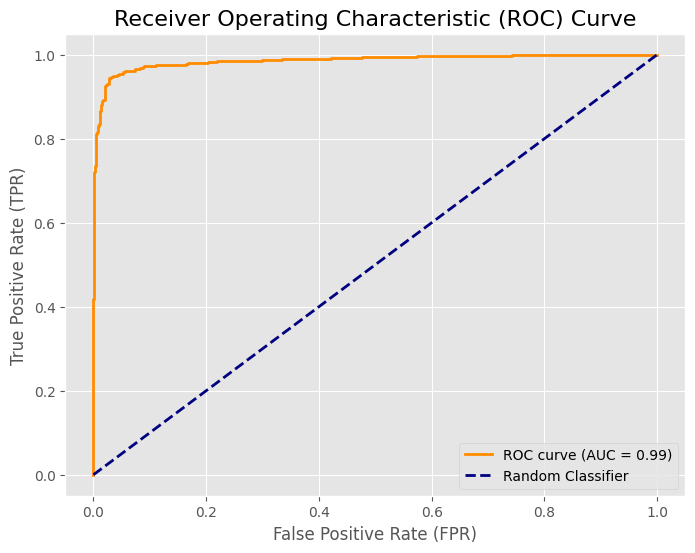

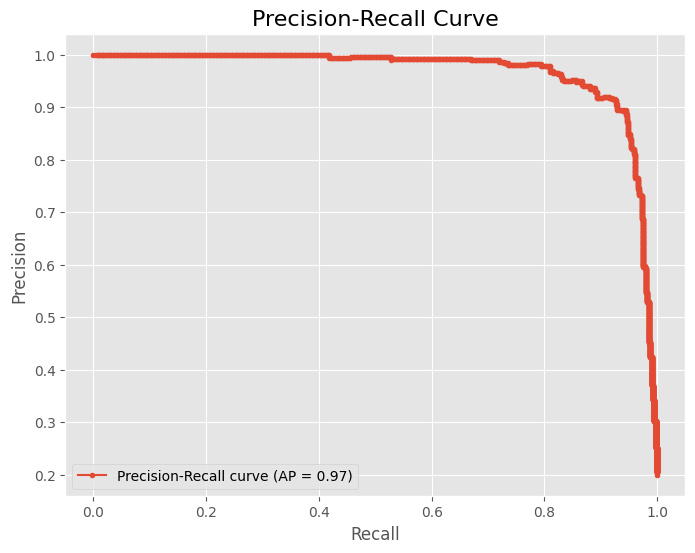


--- Optimal Threshold for Maximum F1-score ---
Optimal Threshold: 0.7216
Maximum F1-score at this threshold: 0.9026


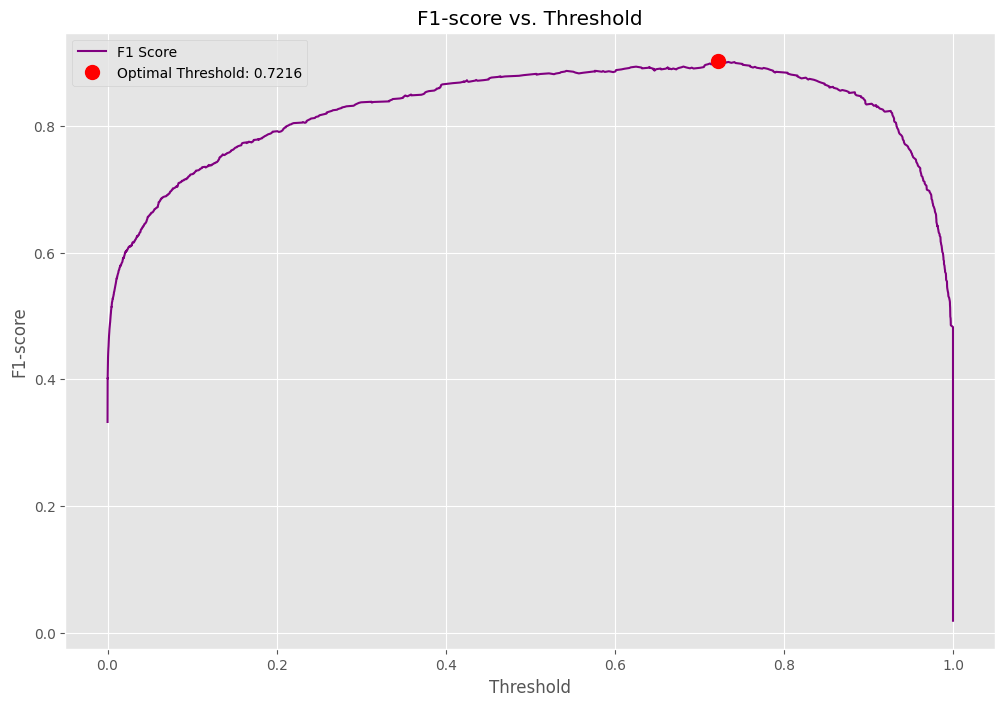

In [43]:
# --- Plotting Metrics ---

# Get the probability scores for the validation set
y_probs_tuned = grid_search.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_probs_tuned)

# Get FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Get precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, y_probs_tuned)

# Calculate the Average Precision score
ap_score = average_precision_score(y_test, y_probs_tuned)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Precision-Recall curve (AP = {ap_score:.2f})')
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(True)
plt.legend(loc='lower left')
plt.show()


# --- Finding and Printing the Optimal Threshold ---
y_val_probs_tuned = grid_search.predict_proba(X_val_scaled)[:, 1]

# Get precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_probs_tuned)

# Calculate the F1-score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Find the threshold that gives the maximum F1-score
optimal_threshold_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_index]
max_f1_score = f1_scores[optimal_threshold_index]

print("\n--- Optimal Threshold for Maximum F1-score ---")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Maximum F1-score at this threshold: {max_f1_score:.4f}")

# Plot the F1-score vs. Threshold to visualize the optimal point
plt.figure(figsize=(12, 8))
plt.plot(thresholds, f1_scores[:-1], 'purple', label='F1 Score')
plt.plot(optimal_threshold, max_f1_score, 'ro', markersize=10, label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.title('F1-score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make new predictions based on the optimal threshold
y_pred_optimized = (y_probs_tuned >= optimal_threshold).astype(int)

# Re-evaluate the model with the new predictions
print("--- Re-evaluated Model Performance on Test Set with Optimal Threshold ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_optimized))

--- Re-evaluated Model Performance on Test Set with Optimal Threshold ---
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1648
           1       0.94      0.87      0.90       411

    accuracy                           0.96      2059
   macro avg       0.95      0.93      0.94      2059
weighted avg       0.96      0.96      0.96      2059

